`EJERCICIOS`
* **Ajustar la cantidad de unidades en cada capa recurrente en la configuración apilada, así como la cantidad de dropout**. Las elecciones actuales son en gran medida arbitrarias y, por lo tanto, probablemente subóptimas.
* **Ajustar la tasa de aprendizaje utilizada por el optimizador ``RMSprop``** o **probad con un optimizador diferente**.
* Intentar **utilizar una pila de capas ``Dense`` como regresor encima de la capa recurrente, en lugar de una única capa ``Dense``**.
* **Mejorar la entrada al modelo**: **intentar usar secuencias más largas o más cortas o una tasa de muestreo diferente, o comenzar a hacer ingeniería de características**.

A continuación, procedemos a la reducción del dataset con el objetivo de poder realizar un mayor número de épocas como una estrategia nueva para afrontar la optimización del algoritmo.

 Sin embargo, hay que ser conscientes de que seguramente perjudique el MAE el hecho de perder parte de la información inicial.

In [26]:
import pandas as pd
# Cargar la base de datos en un DataFrame de Pandas
df = pd.read_csv('jena_climate_2009_2016.csv')
# Mostrar las primeras filas de la base de datos para tener una idea de su estructura
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [27]:
import os
import numpy as np

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:30001]  # Seleccionar solo las primeras 10,000 filas
print(header)
print(len(lines))

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

# Normalización de los datos
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
30000
num_train_samples: 15000
num_val_samples: 7500
num_test_samples: 7500


In [28]:
import numpy as np
from tensorflow import keras
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Un modelo simple basado en LSTM (Long Short Term Memory)**

In [29]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
# Número de timesteps en la secuencia de entrada
timesteps = 100
# Dimensionalidad del espacio de características de entrada
input_features = 32
# Dimensionalidad del espacio de características de salida
output_features = 64
# Datos de entrada: ruido aleatorio para mejorar el ejemplo
inputs = np.random.random((timesteps, input_features))
# Estado inicial: un vector de ceros
state_t = np.zeros((output_features,))
# Creamos matrices de pesos aleatorios
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
# input_t es un vector con la forma (input_features,)
for input_t in inputs:
  # Combina la entrada con el estado actual (la salida anterior)
  # para obtener la salida actual. Usamos tanh para agregar no
  # linealidad (podríamos usar cualquier otra función de activación).
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  # Almacena la salida en una lista
  successive_outputs.append(output_t)
  # Actualiza el estado de la red para el próximo timestep
  state_t = output_t
# El resultado final es un tensor de
# rango 2 con la forma (timesteps, output_features)
final_output_sequence = np.stack(successive_outputs, axis=0)

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.25)(inputs)
# Para regularizar la capa Dense, también agregamos
# una capa Dropout después del LSTM.
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset,
                    callbacks=callbacks)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/70
56/56 [==============================] - 26s 426ms/step - loss: 22.1164 - mae: 3.3306 - val_loss: 26.7327 - val_mae: 4.0397
Epoch 2/70
56/56 [==============================] - 23s 402ms/step - loss: 11.9931 - mae: 2.5309 - val_loss: 16.1532 - val_mae: 3.1381
Epoch 3/70
56/56 [==============================] - 21s 377ms/step - loss: 8.7808 - mae: 2.1960 - val_loss: 13.8855 - val_mae: 2.9099
Epoch 4/70
56/56 [==============================] - 24s 434ms/step - loss: 6.8955 - mae: 1.9667 - val_loss: 12.6991 - val_mae: 2.7688
Epoch 5/70
56/56 [==============================] - 24s 422ms/step - loss: 5.8515 - mae: 1.8323 - val_loss: 13.4893 - val_mae: 2.8758
Epoch 6/70
56/56 [==============================] - 24s 421ms/step - loss: 5.4175 - mae: 1.7448 - val_loss: 15.0050 - val_mae: 3.0438
Epoch 7/70
56/56 [==============================] - 22s 377ms/step - loss: 4.9284 - mae: 1.6534 - val_loss: 14.9455 - val_mae: 3.0500
Epoch 8/70
56/56 [==============================] - 23s 399m

En conclusión, con el 75% de los datos se requerirían más de 70 epochs y a los mejor algún ajuste de los parámetros para obtener un error inferior a 2.5.

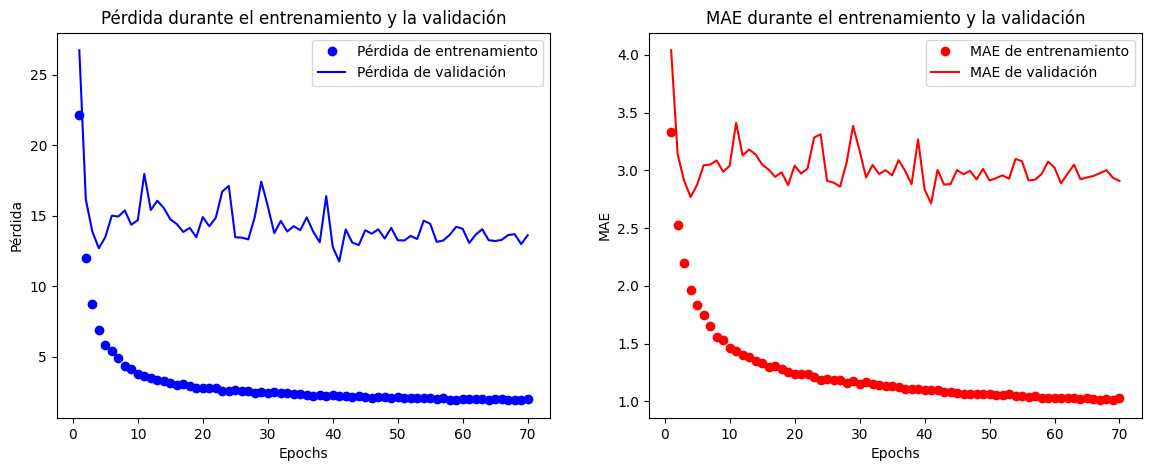

In [32]:
import matplotlib.pyplot as plt
# Extraer los valores de pérdida y MAE de la historia de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Gráfica de pérdida
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'ro', label='MAE de entrenamiento')
plt.plot(epochs, val_mae, 'r', label='MAE de validación')
plt.title('MAE durante el entrenamiento y la validación')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()